https://www.bilibili.com/video/BV1K64y1Q7wu?p=3

MNIST数据集是图像分类中广泛使用的数据集之一（1980年代的数据集），但是作为基准数据及过于简单，所以使用类似但是更复杂一点的Fashion-MNIST数据集

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

In [2]:
d2l.use_svg_display()

## 简单认识MNIST数据

In [3]:
# 通过Totensor实例将图像数据从PIL类型变成32位浮点数格式
# 这个函数同时会进行归一化,除以255缩放到0-1之间
trans=transforms.ToTensor()

mnist_train=torchvision.datasets.FashionMNIST(root='../data',train=True,download=True,transform=trans)
mnist_test=torchvision.datasets.FashionMNIST(root='../data',train=False,download=True,transform=trans)

len(mnist_train),len(mnist_test)

(60000, 10000)

In [4]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

Fashion-MNIST中包含的10个类别分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数用于在数字标签索引及其文本名称之间进行转换。

下面的函数主要就是可视化，查看一下图片的样子

In [5]:
def get_fashion_mnista_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签。"""
    text_labels = [
        't-shairt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

next是内建函数，生成器（yield）自带有next方法，参考“[相关-5.python的yield使用（生成器和迭代器）](https://blog.csdn.net/Castlehe/article/details/119386749)”

torch.Size([18, 1, 28, 28])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F2E4A25708>,
      dtype=object)

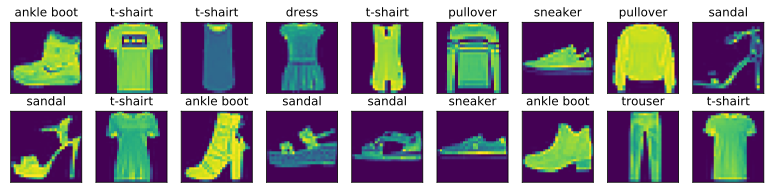

In [6]:
X,y=next(iter(data.DataLoader(mnist_train,batch_size=18)))
print(X.shape)
show_images(X.reshape(18,28,28),2,9,titles=get_fashion_mnista_labels(y))

参考“[相关-5.python的yield使用（生成器和迭代器）](https://blog.csdn.net/Castlehe/article/details/119386749)” 

把上述代码改成下面的，每个批次使用的数据就不一样啦，哈哈

In [7]:
data_iterator=iter(data.DataLoader(mnist_train,batch_size=18))
X,y=next(data_iterator)
print(X.shape)
print(y)
X2,y2=next(data_iterator)
print(X2.shape)
print(y2)

torch.Size([18, 1, 28, 28])
tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0])
torch.Size([18, 1, 28, 28])
tensor([6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8])


这里的[1,28,28]表示这是单通道图像，其实是灰度图，应该是黑白的，只是显示成了这个颜色。

如果想要调节显示的颜色，可以使用`ax.imshow(img.numpy(),cmap="binary")`，然后就可以看到灰色了

参考：[Matplotlib的imshow()函数颜色映射（cmap的取值）](https://blog.csdn.net/qq_28485501/article/details/82656614)

读取一小批量数据，大小为`batch_size`

## 数据读取速度

In [1]:
from multiprocessing import cpu_count
print(cpu_count())

8


In [9]:
batch_size=256

def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4

train_iter=data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers())

timer=d2l.Timer()

for X,y in train_iter:
    continue

f'{timer.stop():.2f} sec'

'3.99 sec'

+ 通常，模型训练很快，在GPU上；但是数据读取会很慢，取决于CPU。
+ 所以会在训练之前，看一下数据读取的速度，要保证数据读取速度至少要不慢于训练速度，至少要快一点
+ CPU数据读取速度和GPU训练速度不匹配，是常见的性能瓶颈之一。
+ benchnmark一下数据（基准）

## 规范的数据加载函数

In [10]:
trans=[transforms.ToTensor()]
resize=(10,20)
trans.insert(0,transforms.Resize(resize))
trans
# 对下面函数的部分内容详细查看

[Resize(size=(10, 20), interpolation=PIL.Image.BILINEAR), ToTensor()]

可以看到，后插的resize排在list的第一位，
+ 先进行resize，
+ 然后再把图变成tensor，同时归一化到0-1范围，resize之后图会变小，这样会比较快

In [11]:
def load_data_fashion_mnist(batch_size,resize=None):
    """下载Fashion-MNIST数据集 将其加载到内存中"""
    trans=[transforms.ToTensor()]
    if resize:
        # trans是一个list，list.insert 插入一个元素 
        # 0是插入的index，可以打印出来看看的,如上
        trans.insert(0,transforms.Resize(resize))
    trans=tranforms.Compose(trans)
    mnist_train=torchvision.datasets.FashionMNIST(root="../data",train=True,transform=trans,download=True)
    mnist_test=torchvision.datasets.FashionMNIST(root="../data",train=False,transform=trans,download=True)
    return (data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers()), 
            data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=get_dataloader_workers()))